# Generating a Bi-Monthly Maximum Water Course Level dataset


In [45]:
import bom_water
from sidecar import Sidecar
from ipyleaflet import Map, GeoJSON, Polygon
from IPython.display import display, clear_output, HTML, JSON
import shapely
import shapely.geometry
import json
import requests
import sys
from geojson import Feature, FeatureCollection, Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime as dt
import logging
import sys


### Setup some constants

In [12]:
#Get an instance of the api package that will be used to access the BoM service

bm = bom_water.BomWater()
procedure = bm.procedures.Pat3_C_B_1_DailyMax 
prop = bm.properties.Water_Course_Level
display(f'Procedure: {procedure}, Property: {prop}')

'Procedure: Pat3_C_B_1_DailyMax, Property: Water Course Level'

In [13]:
def write_json_features(features, file):
    collection = FeatureCollection(features)
    with open(file, "w") as f:
        f.write('%s' % collection)

In [14]:
logging.basicConfig(
    level=logging.INFO, 
    format='[{%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(filename='tmp5a.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

logger = logging.getLogger('TS_Saver')

### Bounding Box for the MDB

This bounding box is to do a first pass filter 

In [15]:
low_left_lat = -37.505032
low_left_long = 138.00
upper_right_lat = -24.00
upper_right_long = 154.00

lower_left_coords = f'{low_left_lat} {low_left_long}'
upper_right_coords = f'{upper_right_lat} {upper_right_long}'

### Filtering gauges using the bounding box and static station Id list

In [16]:
station_info=[{"station_id": "A4260903", "crest_height": 3.3},
{"station_id": "A4260519", "crest_height": 6.1},
{"station_id": "A4260517", "crest_height": 9.8},
{"station_id": "A4260515", "crest_height": 13.2},
{"station_id": "A4260513", "crest_height": 16.3},
{"station_id": "A4260511", "crest_height": 19.2},
{"station_id": "A4260509", "crest_height": 22.1},
{"station_id": "A4260507", "crest_height": 24.6},
{"station_id": "A4260505", "crest_height": 27.4},
{"station_id": "425010", "crest_height": 30.8},
{"station_id": "414209", "crest_height": 47.9}]
response = bm.request(bm.actions.GetFeatureOfInterest, None, prop, procedure, None, None, lower_left_coords, upper_right_coords  )
lock_sites = []
if response.status_code == 200:
    response_json = bm.xml_to_json(response.text)
    '''bomwater creates a FeatureCollection which can be used for mapping'''
    feature_list = bm.create_feature_list(response_json, None )
    for f in feature_list['features']:

        # if f.properties['stationNo'] in station_ids:
        found = list(filter(lambda x:x["station_id"]==f.properties['stationNo'],station_info))
        if found:
            print(f'Match found: {f} and {found}')
            lock_sites.append(f)
            
else:
    print(response.status_code)


Match found: {"geometry": {"coordinates": [142.759783, -34.599668], "type": "Point"}, "properties": {"long_name": "http://bom.gov.au/waterdata/services/stations/414209", "name": "MURRAY_@_LOCK_15", "stationId": null, "stationNo": "414209"}, "type": "Feature"} and [{'station_id': '414209', 'crest_height': 47.9}]
Match found: {"geometry": {"coordinates": [141.9045, -34.11], "type": "Point"}, "properties": {"long_name": "http://bom.gov.au/waterdata/services/stations/425010", "name": "MURRAY@L10_WENTWORTH", "stationId": null, "stationNo": "425010"}, "type": "Feature"} and [{'station_id': '425010', 'crest_height': 30.8}]
Match found: {"geometry": {"coordinates": [139.615749, -34.35095], "type": "Point"}, "properties": {"long_name": "http://bom.gov.au/waterdata/services/stations/A4260903", "name": "River_Murray_at_Lock_1_Downstream_(AMTD_274.3km)", "stationId": null, "stationNo": "A4260903"}, "type": "Feature"} and [{'station_id': 'A4260903', 'crest_height': 3.3}]
Match found: {"geometry": {

### Process and save raw and result data
- Load required gauge data 
- Convert to desired timestep (eg bi monthly max)
- Write all data to disk (raw and processed)

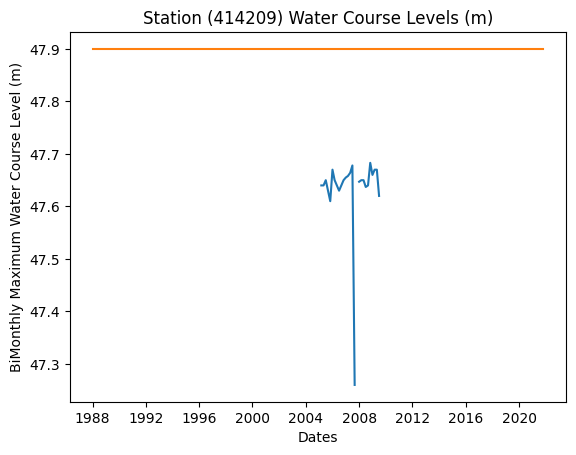

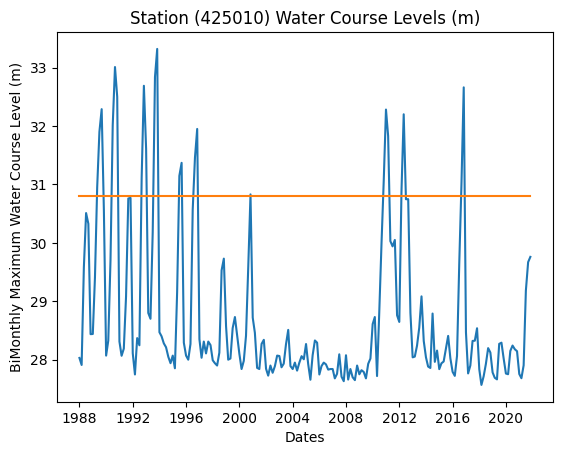

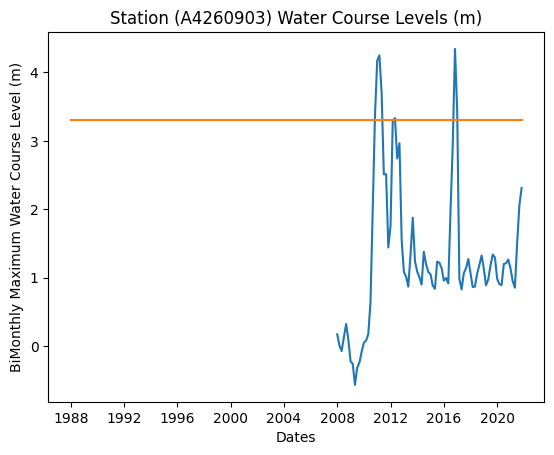

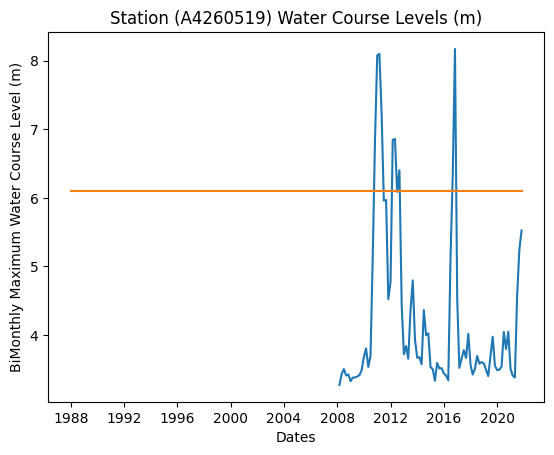

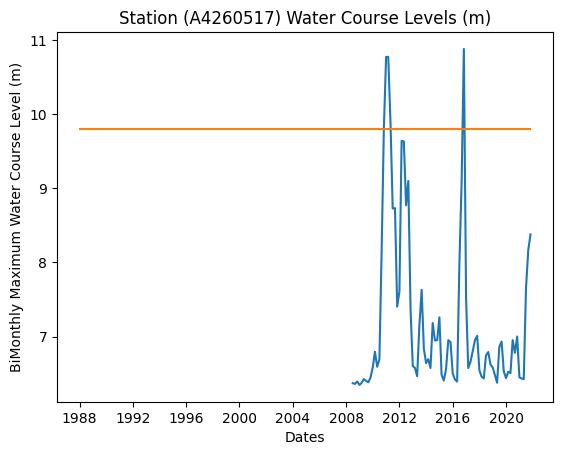

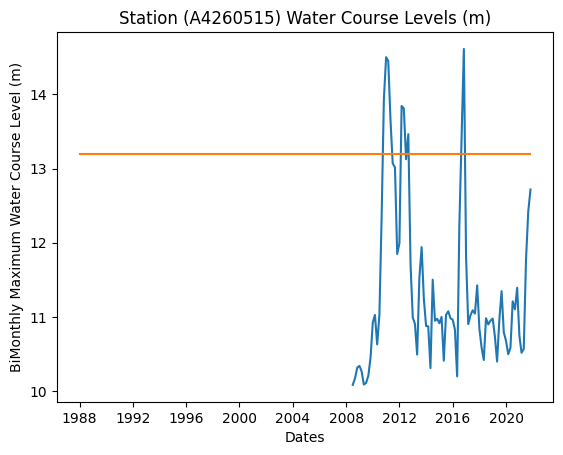

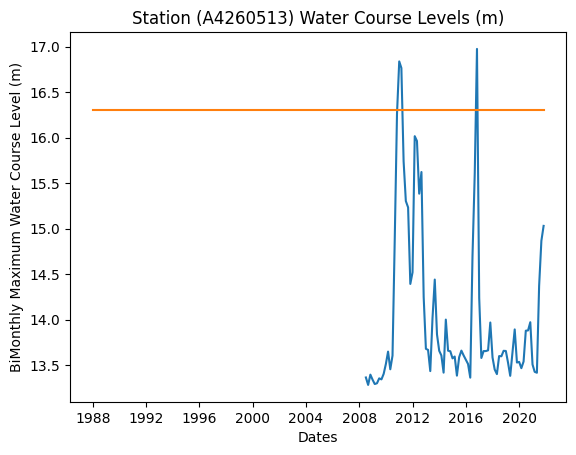

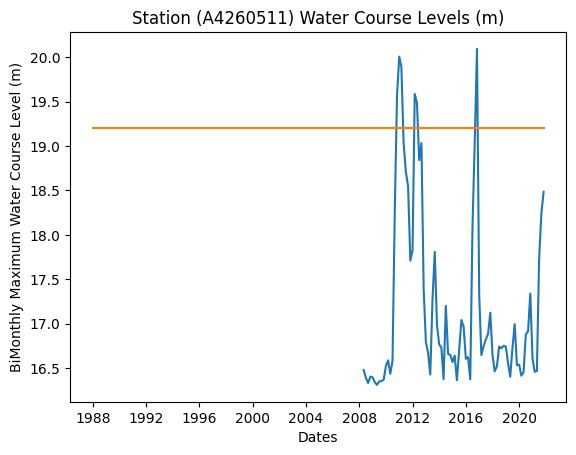

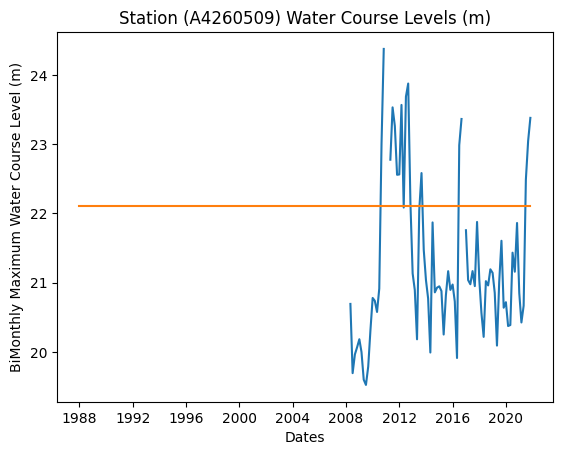

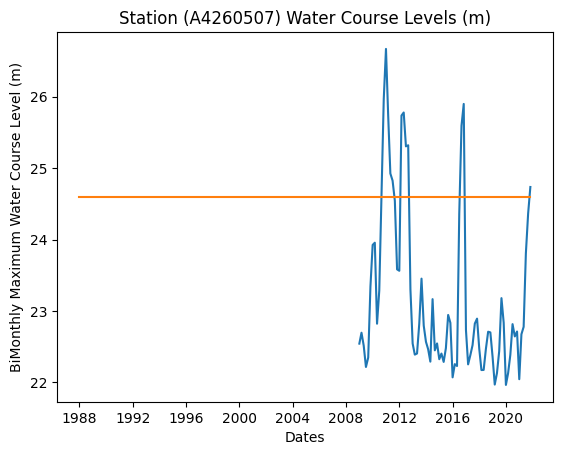

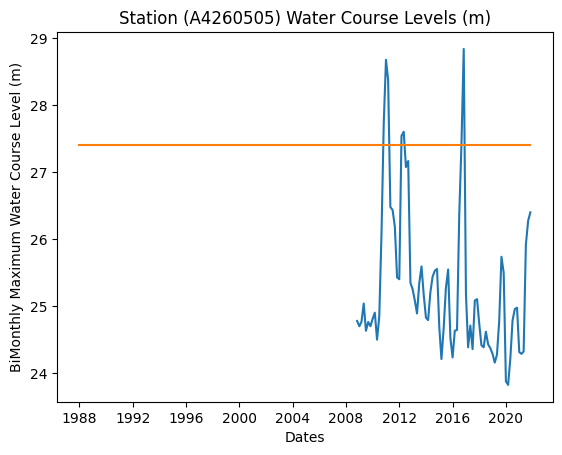

In [44]:
'''Note: Folders should exist before running'''
#Create a dataframe to frame a constant period. As gauge observation data will have varing start and end dates
date1 = dt.date(1988, 1, 1)
date2 = dt.date(2021, 12, 31)
dates = {'Timestamp[UTC]':pd.date_range(start=date1, end=date2)}
values = pd.Series(-1, range(len(dates)))
period = pd.DataFrame(dates, )
period['Timestamp[UTC]'] = pd.to_datetime(period['Timestamp[UTC]'])
#Define the period requested from the BoM Water service
t_begin = "1988-01-01T01:00:00+10"
t_end = "2021-12-31T00:00:00+10"
#Define the Procedure and Properties to request from the service
procedure = bm.procedures.Pat3_C_B_1_DailyMax  
prop = bm.properties.Water_Course_Level
result_set = []

for sites in lock_sites:
    try:
        #Request from BoM Water server
        response = bm.request(bm.actions.GetObservation, sites['properties']['stationNo'], prop, procedure, t_begin, t_end)
        ts = bm.parse_get_data(response)
        stationNo = sites['properties']['stationNo']
        if len(ts.index) < 1:
            logger.warning(f'Data length is zero for station: {stationNo}')
        else:
            dir = f'./bomwater_data/mdb_water_course_level/'
            #Save raw data
            ts.to_csv(f'{dir}{stationNo}.csv')
            station_data_pd = ts.reset_index()
            #Get Station from filter list
            found = list(filter(lambda x:x["station_id"]==stationNo,station_info))
            #Merge raw data with static period to make standard length files and so bi monthly periods start at the same month
            station_data_pd = station_data_pd.drop(['Quality','Interpolation'], axis=1)
            station_data_pd = period.merge(station_data_pd, how='outer', on='Timestamp[UTC]')
            #Group by bi monthly max
            grouped = station_data_pd.groupby(pd.Grouper(freq="2MS", key='Timestamp[UTC]'))['Value[m]'].max()
            result = pd.DataFrame(grouped)
            #Include the crest height with the final dataset
            result['Structure Crest Height(m)'] = found[0]['crest_height']
            result = result.rename({'Value[m]': 'BiMonthly Maximum Water_Course_Level(m)'}, axis=1)
            #Save result to same directory as the raw data
            result.to_csv(f'{dir}biMonthlyMax{stationNo}.csv')
            result_set.append(result)
            
            y = result['BiMonthly Maximum Water_Course_Level(m)']
            x = result.index
            plt.figure()
            plt.title(f'Station ({stationNo}) Water Course Levels (m)')
            plt.ylabel('BiMonthly Maximum Water Course Level (m)')
            plt.xlabel('Dates')
            plt.plot( x, y, label=stationNo )
            crest_height = pd.Series(found[0]['crest_height'], index=range(len(result.index)))
            plt.plot(x, crest_height, label='Crest Height')
            

            plt.savefig(f'{dir}{stationNo}_plot.jpg')

            
            # plt.legend(result, stationNo)
            # plt.close()
            
    except:
        e = sys.exc_info()[0]
        stationNo = sites['properties']['stationNo']
        logger.warning(f'Processing failed with system info: {e} for station: {stationNo}')
        
# for res in result_set:
    